### Libraries

In [21]:
import os
import cv2
from collections import defaultdict
import pandas as pd
import glob

### Imformation of the HMDB51 dataset

In [22]:
import os
import cv2
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_video_directory(video_dir):
    """
    Analyzes videos in the given directory and its subdirectories.
    
    Parameters:
    video_dir (str): Path to the directory containing video files.
    
    Returns:
    dict: A dictionary containing analysis results.
    """
    video_extensions = ['.avi', '.mp4', '.mov']
    analysis_results = {
        'total_clips': 0,
        'class_clips': defaultdict(int),
        'total_duration': 0,
        'action_categories': set(),
        'resolution_counts': defaultdict(int),
        'fps_counts': defaultdict(int),
        'duration_stats': {'min': float('inf'), 'max': 0, 'total': 0},
        'video_lengths': []
    }
    
    for root, _, files in os.walk(video_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in video_extensions):
                file_path = os.path.join(root, file)
                try:
                    cap = cv2.VideoCapture(file_path)
                    if not cap.isOpened():
                        print(f"Error opening video file: {file_path}")
                        continue
                    
                    # Get video properties
                    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    fps = int(cap.get(cv2.CAP_PROP_FPS))
                    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    duration = frame_count / fps
                    
                    # Update analysis results
                    analysis_results['total_clips'] += 1
                    action_category = os.path.basename(os.path.dirname(file_path))
                    analysis_results['class_clips'][action_category] += 1
                    analysis_results['total_duration'] += duration
                    analysis_results['action_categories'].add(action_category)
                    analysis_results['resolution_counts'][f'{width}x{height}'] += 1
                    analysis_results['fps_counts'][fps] += 1
                    analysis_results['video_lengths'].append(duration)
                    
                    # Update duration stats
                    analysis_results['duration_stats']['min'] = min(analysis_results['duration_stats']['min'], duration)
                    analysis_results['duration_stats']['max'] = max(analysis_results['duration_stats']['max'], duration)
                    analysis_results['duration_stats']['total'] += duration
                    
                    cap.release()
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
    
    # Calculate average duration
    if analysis_results['total_clips'] > 0:
        analysis_results['duration_stats']['avg'] = analysis_results['duration_stats']['total'] / analysis_results['total_clips']
    
    return analysis_results

def create_analysis_dataframes(results):
    """
    Creates pandas DataFrames from the analysis results.
    
    Parameters:
    results (dict): The analysis results dictionary.
    
    Returns:
    tuple: A tuple containing four DataFrames (general_info, class_info, resolution_info, fps_info)
    """
    # General Info DataFrame
    general_info = pd.DataFrame({
        'Metric': ['Total Clips', 'Number of Action Categories', 'Average Duration (s)', 'Longest Clip Duration (s)', 'Shortest Clip Duration (s)'],
        'Value': [
            f"{results['total_clips']:d}",
            f"{len(results['action_categories']):d}",
            f"{results['duration_stats']['avg']:.4f}",
            f"{results['duration_stats']['max']:.4f}",
            f"{results['duration_stats']['min']:.4f}"
        ]
    })
    
    # Class Info DataFrame
    class_info = pd.DataFrame(list(results['class_clips'].items()), columns=['Action Category', 'Number of Clips'])
    class_info = class_info.sort_values('Number of Clips', ascending=False).reset_index(drop=True)
    
    # Resolution Info DataFrame
    resolution_info = pd.DataFrame(list(results['resolution_counts'].items()), columns=['Resolution', 'Count'])
    resolution_info = resolution_info.sort_values('Count', ascending=False).reset_index(drop=True)
    
    # FPS Info DataFrame
    fps_info = pd.DataFrame(list(results['fps_counts'].items()), columns=['FPS', 'Count'])
    fps_info = fps_info.sort_values('FPS').reset_index(drop=True)
    
    return general_info, class_info, resolution_info, fps_info

def plot_video_length_histogram(results):
    """
    Creates and displays a histogram of video lengths, binned by second,
    and returns a DataFrame of video duration counts.
    
    Parameters:
    results (dict): The analysis results dictionary.
    
    Returns:
    pd.DataFrame: A DataFrame containing the count of videos for each duration.
    """
    plt.figure(figsize=(12, 6))
    
    # Convert durations to integers (rounding down to nearest second)
    durations = [int(duration) for duration in results['video_lengths']]
    
    # Calculate the range for the bins
    max_duration = max(durations)
    bins = range(0, max_duration + 2)  # +2 to include the max value and have a bin after it
    
    # Create the histogram
    hist, bin_edges = np.histogram(durations, bins=bins)
    
    # Create a DataFrame of the duration counts
    duration_counts = pd.DataFrame({
        'Duration (seconds)': bin_edges[:-1],
        'Number of Videos': hist
    })
    duration_counts = duration_counts[duration_counts['Number of Videos'] > 0]  # Remove rows with zero counts
    duration_counts = duration_counts.sort_values('Number of Videos', ascending=False).reset_index(drop=True)
    
    plt.hist(durations, bins=bins, align='left', rwidth=0.8, edgecolor='black')
    
    plt.title('Distribution of Video Lengths')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Number of Videos')
    
    # Set x-axis ticks to show every 5 seconds
    plt.xticks(range(0, max_duration + 1, 5))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return duration_counts

In [24]:
# Usage
video_dir = '/Users/holiday/Desktop/Dissertation_code/hmdb51_org'
results = analyze_video_directory(video_dir)

# Create DataFrames
general_info, class_info, resolution_info, fps_info = create_analysis_dataframes(results)

In [25]:
# Display results
print("General Information:")
print(general_info.to_string(index=False))

General Information:
                     Metric   Value
                Total Clips    6766
Number of Action Categories      51
       Average Duration (s)  3.1496
  Longest Clip Duration (s) 35.4333
 Shortest Clip Duration (s)  0.6333


In [26]:
print("\nClass Information:")
print(class_info.to_string(index=False))


Class Information:
Action Category  Number of Clips
           walk              548
           turn              240
            run              232
          drink              164
    shake_hands              162
          stand              154
           jump              151
        dribble              145
 swing_baseball              143
            sit              142
     somersault              140
     fall_floor              136
     shoot_ball              131
           clap              130
           kick              130
      kick_ball              128
          laugh              128
 sword_exercise              127
            hit              127
          sword              127
           dive              127
          punch              126
           talk              120
            hug              118
        fencing              116
     ride_horse              116
           push              116
      handstand              113
   climb_stairs        

In [27]:
print("\nResolution Distribution:")
print(resolution_info.to_string(index=False))


Resolution Distribution:
Resolution  Count
   320x240   3523
   352x240    732
   416x240    477
   560x240    446
   432x240    393
   424x240    200
   300x240    141
   480x240    137
   360x240    128
   288x240    117
   592x240     96
   304x240     68
   576x240     60
   292x240     47
   448x240     38
   420x240     30
   312x240     26
   324x240     18
   568x240     14
   428x240     12
   400x240     12
   436x240      7
   348x240      7
   496x240      5
   176x240      4
   528x240      4
   332x240      4
   328x240      4
   336x240      3
   180x240      3
   440x240      3
   308x240      2
   452x240      2
   456x240      1
   368x240      1
   316x240      1


In [28]:
print("\nFPS Distribution:")
print(fps_info.to_string(index=False))


FPS Distribution:
 FPS  Count
  30   6766


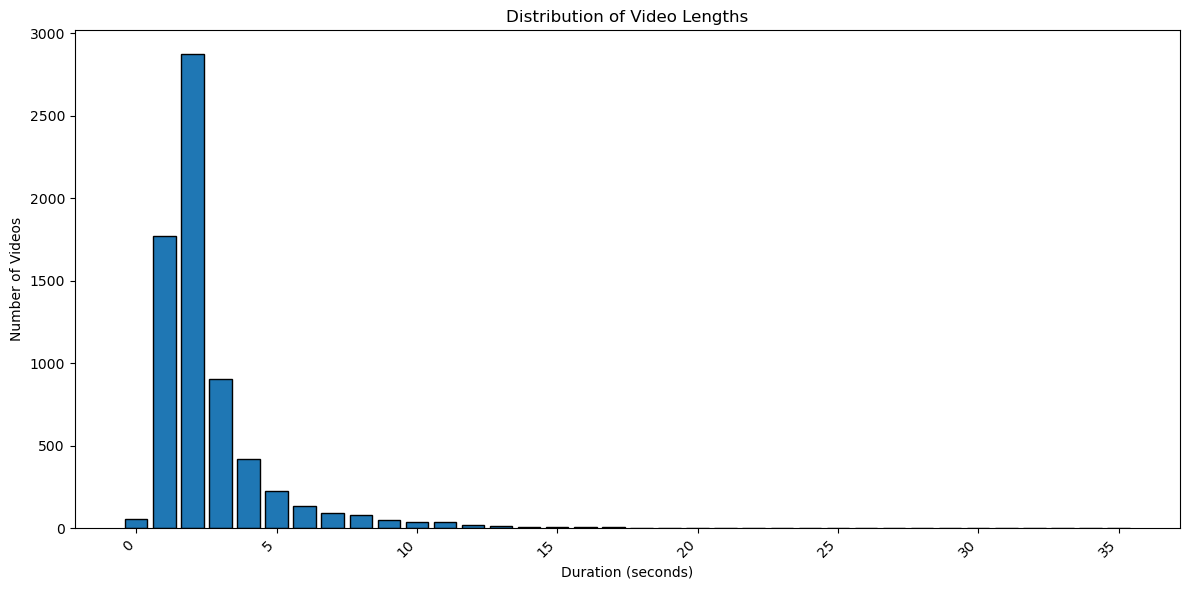


Video Duration Distribution (top 10):
 Duration (seconds)  Number of Videos
                  2              2874
                  1              1773
                  3               903
                  4               418
                  5               227
                  6               137
                  7                95
                  8                81
                  0                56
                  9                50


In [31]:
# Display histogram and get duration distribution DataFrame
duration_distribution = plot_video_length_histogram(results)

# Display duration distribution
print("\nVideo Duration Distribution (top 10):")
print(duration_distribution.head(10).to_string(index=False))

### The combination of extracting labels, extracting frames and allocating frames

In [3]:
import cv2
import os


def extract_video_labels(file_path):
    '''
    Extracts video labels from a given file.
    
    Parameters:
    file_path (str): Path to the label file.
    
    Returns:
    dict: A dictionary mapping video names to their corresponding labels (1 for training, 2 for testing).
    '''
    with open(file_path, 'r') as file:
        lines = file.readlines()
    video_labels = {}
    for line in lines:
        video_name, video_id = line.strip().split()
        video_labels[video_name] = int(video_id)
    return video_labels

def extract_and_allocate_frames(video_path, output_dir, video_name, is_training, action):
    '''
    Extracts frames from a video and saves them in the appropriate directory.
    
    Parameters:
    video_path (str): Path to the input video file.
    output_dir (str): Base directory for output.
    video_name (str): Name of the video file.
    is_training (bool): True if the video is for training, False for testing.
    action (str): The action category of the video.
    
    Returns:
    None
    '''
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_interval = int(fps * 0.5)

    save_dir = os.path.join(output_dir, 'train' if is_training else 'test', action, video_name)
    os.makedirs(save_dir, exist_ok=True)

    for frame_number in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        if frame_number % frames_interval == 0:  # Save one frame per second
            frame_filename = os.path.join(save_dir, f'frame_{frame_number:04d}.jpg')
            cv2.imwrite(frame_filename, frame)

    cap.release()
    print(f'Extracted frames from {video_name} to {save_dir}')

def find_video_file(action_dir, video_name):
    '''
    Finds the video file in the given directory.
    
    Parameters:
    action_dir (str): Directory containing the video files.
    video_name (str): Name of the video file to find.
    
    Returns:
    str or None: Path to the video file if found, None otherwise.
    '''
    # Try different possible extensions
    for ext in ['.avi', '.mp4', '.mov']:
        # Try with single extension
        video_path = os.path.join(action_dir, f'{video_name}{ext}')
        if os.path.exists(video_path):
            return video_path

        # Try without duplicate extension
        if video_name.endswith(ext):
            video_path = os.path.join(action_dir, f'{video_name}')
            if os.path.exists(video_path):
                return video_path

    return None

def process_videos(label_dir, video_dir, output_dir):
    '''
    Processes all videos according to their labels and extracts frames.
    
    Parameters:
    label_dir (str): Directory containing label files.
    video_dir (str): Directory containing video files.
    output_dir (str): Directory to save extracted frames.
    
    Returns:
    None
    '''
    label_files = glob.glob(os.path.join(label_dir, '*_test_split1.txt'))
    print(f"Found {len(label_files)} label files")

    for label_file in label_files:
        action = os.path.basename(label_file).split('_test_split1.txt')[0]
        print(f"Processing action: {action}")

        action_dir = os.path.join(video_dir, action)
        if not os.path.isdir(action_dir):
            print(f"Action directory not found: {action_dir}")
            continue

        video_labels = extract_video_labels(label_file)
        print(f"Found {len(video_labels)} video labels for {action}")

        train_count = sum(1 for label in video_labels.values() if label == 1)
        test_count = sum(1 for label in video_labels.values() if label == 2)
        print(f"Training videos: {train_count}, Testing videos: {test_count}")

        for video_name, label in video_labels.items():
            if label in [1, 2]:  # 1 for training, 2 for testing
                video_path = find_video_file(action_dir, video_name)
                if video_path:
                    print(f"Processing video: {video_path}")
                    extract_and_allocate_frames(video_path, output_dir, video_name, label == 1, action)
                else:
                    print(f"Video file not found for: {video_name} in {action_dir}")

        print(f"Finished processing {action}")

# Define directories
label_dir = '/Users/holiday/Desktop/Dissertation_code/Test_Train_Split/testTrainMulti_7030_splits'
video_dir = '/Users/holiday/Desktop/Dissertation_code/hmdb51_org'
output_dir = '/Users/holiday/Desktop/Dissertation_code/Extract_Frames_0.5s'

# Create output directories
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

# Run the process
process_videos(label_dir, video_dir, output_dir)
print('Done processing videos and allocating frames.')

Found 51 label files
Processing action: swing_baseball
Found 143 video labels for swing_baseball
Training videos: 70, Testing videos: 30
Processing video: /Users/holiday/Desktop/Dissertation_code/hmdb51_org/swing_baseball/8YearOldHitsaHomeRunBaseball_swing_baseball_f_cm_np1_fr_bad_0.avi
Extracted frames from 8YearOldHitsaHomeRunBaseball_swing_baseball_f_cm_np1_fr_bad_0.avi to /Users/holiday/Desktop/Dissertation_code/Extract_Frames_0.5s/test/swing_baseball/8YearOldHitsaHomeRunBaseball_swing_baseball_f_cm_np1_fr_bad_0.avi
Processing video: /Users/holiday/Desktop/Dissertation_code/hmdb51_org/swing_baseball/BaseBallSweetSwingsingle_swing_baseball_f_nm_np1_ba_bad_0.avi
Extracted frames from BaseBallSweetSwingsingle_swing_baseball_f_nm_np1_ba_bad_0.avi to /Users/holiday/Desktop/Dissertation_code/Extract_Frames_0.5s/test/swing_baseball/BaseBallSweetSwingsingle_swing_baseball_f_nm_np1_ba_bad_0.avi
Processing video: /Users/holiday/Desktop/Dissertation_code/hmdb51_org/swing_baseball/BaseballHiti